In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import precision_recall_fscore_support
import os
import random
import copy
from matplotlib import pyplot as plt
%matplotlib inline

## If using google collab, run once then comment out once google drive is connected

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

## Variables to change

In [3]:
# Environment variables (doesn't need changing)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# directories ("experiment" only needs to be changed)
path = '/content/gdrive/MyDrive/'
classes = np.sort(os.listdir(path + 'data/val'))
experiment = 'run1' # folder where models from each epoch will be saved per experiment 
if 'models' not in os.listdir(path):
  os.mkdir(path + 'models')
if experiment not in os.listdir(path + 'models'):
  os.mkdir(path + 'models/' + experiment)

# training (change as needed)
balance_classes = True
pretrain = True
class_weighted_loss = False
class_weights = torch.Tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(device)
model_input_size = 224
epochs = 20 # number of times entire train set is trained on
lr = 0.001
momentum = 0.9


# Augmentation variables (change as needed)
brightness = 0.1
contrast = 0.1
saturation = 0.1
hue = 0.1
prob_horz_flip = 0.5
prob_vert_flip = 0.5
rotation = 360

In [4]:
# helper functions
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight 

## If using a custom CNN, modify everything below `super().__init__()`

In [5]:
# custom CNN (this one is AlexNet, so not custom)
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(64, 192, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(192, 384, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(384, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
            )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 7),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
# Setup data loaders
if pretrain:
  train_transform = transforms.Compose([transforms.Resize(model_input_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225]),
                                  transforms.RandomRotation(rotation),
                                  transforms.ColorJitter(brightness, contrast, saturation, hue),
                                  transforms.RandomHorizontalFlip(p=prob_horz_flip),
                                  transforms.RandomVerticalFlip(p=prob_vert_flip)]
                                  )
  val_transform = transforms.Compose([transforms.Resize(model_input_size),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])])
else:
  train_transform = transforms.Compose([transforms.Resize(model_input_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5, 0.5, 0.5], 
                                                      [0.5, 0.5, 0.5]),
                                  transforms.RandomRotation(rotation),
                                  transforms.ColorJitter(brightness, contrast, saturation, hue),
                                  transforms.RandomHorizontalFlip(p=prob_horz_flip),
                                  transforms.RandomVerticalFlip(p=prob_vert_flip)]
                                  )
  val_transform = transforms.Compose([transforms.Resize(model_input_size),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], 
                                                      [0.5, 0.5, 0.5])])
  
train_dataset = datasets.ImageFolder(path + 'data/train', transform=train_transform)
if balance_classes:
  weights = make_weights_for_balanced_classes(train_dataset.imgs, 7)
  weights = torch.DoubleTensor(weights)                                       
  sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
  trainloader = torch.utils.data.DataLoader(train_dataset, sampler=sampler, batch_size=32, shuffle=False, pin_memory=True, num_workers=2)
else:
  trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)


val_dataset = datasets.ImageFolder(path + 'data/val', transform=val_transform)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)

## Model, loss function, and optimizer can all be changed

In [7]:
### Model setup

# choose a model
net = torchvision.models.mobilenet_v2(pretrained=pretrain)
if pretrain:
  for param in net.parameters():
      param.requires_grad = False
  num_feats = net.classifier[-1].in_features
  bias = not net.classifier[-1].bias == None
  net.classifier[1] = nn.Linear(in_features=num_feats, out_features=7, bias=bias)
net_test = copy.deepcopy(net)
net = net.to(device)

# choose a loss function
if class_weighted_loss:
  criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
  criterion = nn.CrossEntropyLoss()

# choose an optimizer
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
## Train

lowest_val_loss = np.inf
epoch_high = 0
loss_values, val_loss_values = [], []
for epoch in range(0, epochs):  # loop over the dataset multiple times

    train_loss = 0.0
    
    net.train()
    for data in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # add loss
        train_loss += loss.item() * inputs.size(0)
    loss_values.append(train_loss / len(train_dataset))
        
    valid_loss = 0.0
    net.eval()     # Optional when not using Model Specific layer
    all_outputs, all_labels = [], []
    for data in valloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        valid_loss = loss.item() * inputs.size(0)
        all_outputs += torch.max(outputs.data, 1)[1].tolist()
        all_labels += labels.tolist()
    val_loss_values.append(valid_loss / len(val_dataset))
    ppv, sens, _, _ = precision_recall_fscore_support(all_labels, all_outputs, average=None, labels=list(np.sort(pd.Series(all_labels).unique())))
    ppv_dict = {class_name:np.round(p, 3) for class_name, p in zip(classes, ppv)}
    sens_dict = {class_name:np.round(s, 3) for class_name, s in zip(classes, sens)}
    print('PPV:', ppv_dict)
    print('Sensitivity:', sens_dict)
    if valid_loss < lowest_val_loss:
        epoch_high = epoch 
        lowest_val_loss = valid_loss

    print(f'Epoch {epoch} \t\t Training Loss: {np.round(train_loss / len(trainloader), 3)} \t\t Validation Loss: {np.round(valid_loss / len(valloader), 3)}')
    torch.save(net.state_dict(), path + 'models/' + experiment + '/saved_model' + str(epoch) + '.pth')

print('Finished Training')

PPV: {'akiec': 0.077, 'bcc': 0.0, 'bkl': 0.264, 'df': 0.0, 'mel': 0.054, 'nv': 1.0, 'vasc': 0.013}
Sensitivity: {'akiec': 0.021, 'bcc': 0.0, 'bkl': 0.343, 'df': 0.0, 'mel': 0.073, 'nv': 0.001, 'vasc': 0.684}
Epoch 0 		 Training Loss: 53.384 		 Validation Loss: 1.924
PPV: {'akiec': 0.0, 'bcc': 0.277, 'bkl': 0.328, 'df': 0.011, 'mel': 0.096, 'nv': 0.908, 'vasc': 0.015}
Sensitivity: {'akiec': 0.0, 'bcc': 0.16, 'bkl': 0.281, 'df': 0.429, 'mel': 0.135, 'nv': 0.186, 'vasc': 0.316}
Epoch 1 		 Training Loss: 43.476 		 Validation Loss: 1.497
PPV: {'akiec': 0.171, 'bcc': 0.316, 'bkl': 0.221, 'df': 0.009, 'mel': 0.031, 'nv': 0.861, 'vasc': 0.031}
Sensitivity: {'akiec': 0.143, 'bcc': 0.146, 'bkl': 0.42, 'df': 0.214, 'mel': 0.009, 'nv': 0.495, 'vasc': 0.263}
Epoch 2 		 Training Loss: 41.219 		 Validation Loss: 1.085
Finished Training


Text(0, 0.5, 'Val Loss')

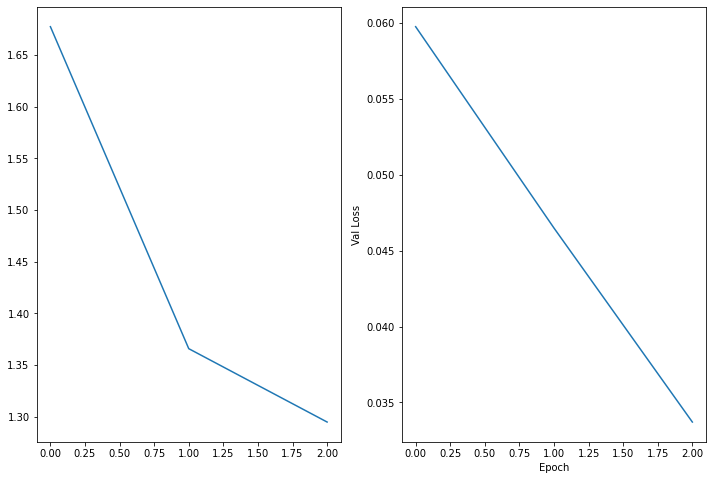

In [10]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), loss_values, '-')
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.plot(range(epochs), val_loss_values, '-')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')

In [11]:
# Test a model on val set
model_path = path + 'models/saved_model' + str(epoch_high) + '.pth'
net_test.load_state_dict(torch.load(model_path))
preds, truth = [], []
with torch.no_grad():
    for data in valloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net_test(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        preds += predicted.tolist()
        truth += labels.tolist()
ppv, sens, _, _ = precision_recall_fscore_support(truth, preds, average=None, labels=list(np.sort(pd.Series(truth).unique())))
ppv_dict = {class_name:np.round(p, 3) for class_name, p in zip(classes, ppv)}
sens_dict = {class_name:np.round(s, 3) for class_name, s in zip(classes, sens)}
print('PPV:', ppv_dict)
print('Sensitivity:', sens_dict)

FileNotFoundError: ignored